### Basic Import

In [0]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (44.7 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from google.colab import drive
import cv2

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

### Load the data

In [0]:
# Mount drive
drive.mount('/gdrive',force_remount=True)
drive_root = '/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


Load the dataset (np array) from google drive

In [0]:
saving_path = '/gdrive/My Drive/Applied_Deep_Learning/project'

train_zoom1 = np.load(os.path.join(saving_path, 'train') + '/zoom1.npy')
train_zoom2 = np.load(os.path.join(saving_path, 'train') + '/zoom2.npy')
train_label = np.load(os.path.join(saving_path, 'train') + '/label.npy')

val_zoom1 = np.load(os.path.join(saving_path, 'val') + '/zoom1.npy')
val_zoom2 = np.load(os.path.join(saving_path, 'val') + '/zoom2.npy')
val_label = np.load(os.path.join(saving_path, 'val') + '/label.npy')

Sanity check

In [0]:
assert train_zoom1.shape == train_zoom2.shape
assert len(train_zoom1) == len(train_label)

assert val_zoom1.shape == val_zoom2.shape
assert len(val_zoom1) == len(val_label)

In [0]:
train_zoom1.shape 

(4000, 299, 299, 3)

In [0]:
val_zoom1.shape

(800, 299, 299, 3)

### Prepare the data generator

In [0]:
def other_adjustment(img):
    """
    function: images => images with random brightness, saturation, hue, contrast adjustment
    
    """

    # adjust brightness
    temp_image = tf.image.random_brightness(img,
                                            64.0/255,
                                            seed=None)
    # adjust saturation
    temp_image = tf.image.random_saturation(temp_image,
                                            0,
                                            0.25,
                                            seed=None)
    # adjust hue
    temp_image = tf.image.random_hue(temp_image,
                                     0.04,
                                     seed=None)
    # adjust contrast
    temp_image = tf.image.random_contrast(temp_image,
                                          0,
                                          0.75,
                                          seed=None)

    return temp_image

In [0]:
# Define the image transformations here
batch_size = 16

# if want to adjust brightness, saturation, hue, contrast
# set preprocessing_function to be other_adjustment
train_gen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale=1./255,
                               width_shift_range=(-8, 8),
                               height_shift_range=(-8, 8),
                               rotation_range = 90, 
                               preprocessing_function=None) 


val_gen = ImageDataGenerator(rescale=1./255)

# make sure they use the same random seed so that the order of 
# images at zoom level 1 will match the order of images at zoom level 2

def train_gen_for_two(X1, X2, Y, random_seed = 123):
    genX1 = train_gen.flow(X1,Y, seed = random_seed, batch_size=batch_size)
    genX2 = train_gen.flow(X2, seed = random_seed, batch_size=batch_size)
    while True:
      X1i = genX1.next()
      X2i = genX2.next()
      yield [X1i[0], X2i], X1i[1]

def val_gen_for_two(X1, X2, Y, random_seed = 123):
    genX1 = val_gen.flow(X1,Y, seed = random_seed, batch_size=batch_size)
    genX2 = val_gen.flow(X2, seed = random_seed, batch_size=batch_size)
    while True:
      X1i = genX1.next()
      X2i = genX2.next()
      yield [X1i[0], X2i], X1i[1]

Create final generator

In [0]:
train_flow = train_gen_for_two(train_zoom1, train_zoom2, train_label)
val_flow = val_gen_for_two(val_zoom1, val_zoom2, val_label)

(16, 299, 299, 3)
(16,)


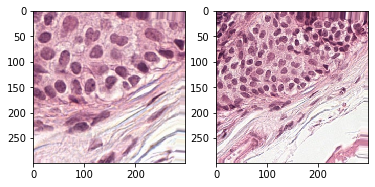

In [0]:
for x, y in train_flow:
  print(x[0].shape)
  print(y.shape)
  plt.subplot(1, 2, 1)
  plt.imshow(x[0][5])
  plt.subplot(1, 2, 2)
  plt.imshow(x[1][5])
  break

### Modeling

Create the model

In [0]:
def create_model(patch_size = 299):
  """
  function: create the model at given patch_size
  
  """

  inception_tower_zoom1 = InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(patch_size, patch_size, 3))

  inception_tower_zoom2 = InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(patch_size, patch_size, 3))

  # freeze the inception model to increase training speed
  inception_tower_zoom1.trainable = False
  inception_tower_zoom2.trainable = False

  # creat the base model
  model_zoom1 = Sequential()
  model_zoom1.add(inception_tower_zoom1)
  model_zoom1.add(GlobalAveragePooling2D())

  model_zoom2 = Sequential()
  model_zoom2.add(inception_tower_zoom2)
  model_zoom2.add(GlobalAveragePooling2D())

  input_zoom1 = Input(shape=(patch_size, patch_size, 3))
  input_zoom2 = Input(shape=(patch_size, patch_size, 3))

  encoded_zoom1 = model_zoom1(input_zoom1)
  encoded_zoom2 = model_zoom2(input_zoom2)

  merged = concatenate([encoded_zoom1, encoded_zoom2])
  dense1 = Dense(256, activation='relu')(merged)
  drop_layer = Dropout(0.5)(dense1)
  dense2 = Dense(126, activation='relu')(drop_layer)

  output = Dense(1, activation='sigmoid')(dense2)
  model = Model(inputs=[input_zoom1, input_zoom2], outputs=output)

  return model

In [0]:
model = create_model()
model.summary()

87916544/87910968 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         21802784    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         21802784    input_4[0][0]                    
_____________________________

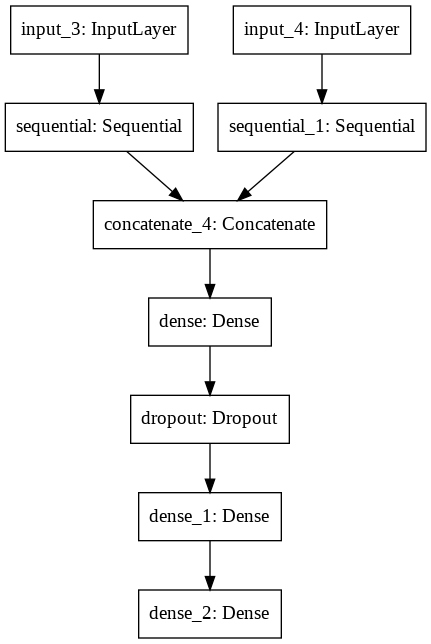

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
batch_size = 16 # save RAM for images preprocess

# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Sanity check - check the model is correct

In [0]:
(zoom1_images, zoom2_images), labels = next(iter(train_flow))

In [0]:
for iter_idx in range(60):
  metrics = model.train_on_batch(x = [zoom1_images, zoom2_images], y = labels)
  if (iter_idx+1)%20 == 0:
    print(f"currently at {iter_idx+1}, with loss {metrics[0]} and acc {metrics[1]}")

currently at 20, with loss 0.23274558782577515 and acc 1.0
currently at 40, with loss 0.07970021665096283 and acc 1.0
currently at 60, with loss 0.026548724621534348 and acc 1.0


Set up check points

In [0]:
checkpoint_dir = os.path.join(drive_root, "Applied_Deep_Learning/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "project")
checkpoint_path = os.path.join(checkpoint_dir, "weights-{epoch:02d}-{val_accuracy:.2f}.hdf5")

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, monitor='val_accuracy',
                                                 verbose=1)


In [0]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/Applied_Deep_Learning/checkpoints/project
Creating a checkpoints directory


Fit the final model

In [0]:
# reduce learning when the loss curve is quite flat
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

In [0]:
model = create_model()

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_flow,
                              epochs=25,
                              validation_data=val_flow, 
                              steps_per_epoch = len(train_zoom1) / batch_size, 
                              validation_steps=len(val_zoom1) / batch_size, 
                              callbacks = [cp_callback, reduce_lr])

Epoch 1/25
249/250 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8436
Epoch 00001: saving model to /gdrive/My Drive/Applied_Deep_Learning/checkpoints/project/weights-01-0.93.hdf5
250/250 [==============================] - 167s 669ms/step - loss: 0.3664 - accuracy: 0.8440 - val_loss: 0.2446 - val_accuracy: 0.9337
Epoch 2/25
249/250 [============================>.] - ETA: 0s - loss: 0.2514 - accuracy: 0.9029
Epoch 00002: saving model to /gdrive/My Drive/Applied_Deep_Learning/checkpoints/project/weights-02-0.90.hdf5
250/250 [==============================] - 160s 641ms/step - loss: 0.2513 - accuracy: 0.9032 - val_loss: 0.2651 - val_accuracy: 0.9025
Epoch 3/25
249/250 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9104
Epoch 00003: saving model to /gdrive/My Drive/Applied_Deep_Learning/checkpoints/project/weights-03-0.93.hdf5
250/250 [==============================] - 159s 636ms/step - loss: 0.2212 - accuracy: 0.9105 - val_loss: 0.1764 - v

Plot the cross-validation result

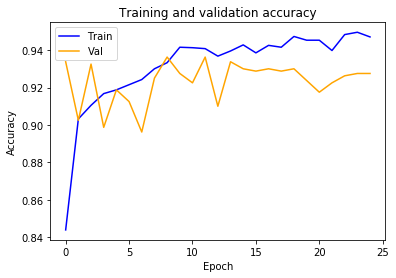

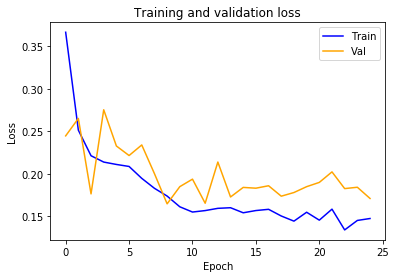

In [0]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

### Make prediction

Load the best model and make prediction on the test set

In [0]:
model = create_model()
# during training
# model.load_weights('/gdrive/My Drive/Applied_Deep_Learning/checkpoints/project/weights-12-0.94.hdf5')

# move to final_deliverable folder
model.load_weights('/gdrive/My Drive/Applied_Deep_Learning/project/final_deliverable/weights-12-0.94.hdf5')

In [0]:
# load the testset image
# Create copy of slide to avoid Google download constrain

testset_image_path = ['/gdrive/My Drive/Applied_Deep_Learning/new_slides/Copy of tumor_075.tif', 
                      '/gdrive/My Drive/Applied_Deep_Learning/new_slides/Copy of tumor_091.tif',
                '/gdrive/My Drive/Applied_Deep_Learning/new_slides/Copy of tumor_096.tif']

testset_mask_path = ['/gdrive/My Drive/Applied_Deep_Learning/new_slides/Copy of tumor_075_mask.tif', 
                     '/gdrive/My Drive/Applied_Deep_Learning/new_slides/Copy of tumor_091_mask.tif',
                '/gdrive/My Drive/Applied_Deep_Learning/new_slides/Copy of tumor_096_mask.tif']

# convert path to slide
def path_to_slide(path):
  return open_slide(path)

testset_tumor_slide = list(map(lambda path: path_to_slide(path), testset_image_path))
testset_mask_slide = list(map(lambda path: path_to_slide(path), testset_mask_path))

In [0]:
# create the rotation function to increase accuracy of the prediction

def test_rotate(action_ind, img):
  """
  function: action_ind, img => img that has been process by action action_ind
    when action_ind = 0 => return the original
         action_ind = 1 => return the img rotated 90 degree
         action_ind = 2 => return the img rotated 180 degree
         action_ind = 3 => return the img rotated 270 degree
         action_ind = 4 => return the img flipped left right
         action_ind = 5 => return the img flipped left right (rotated 90 degree)
         action_ind = 6 => return the img flipped left right (rotated 180 degree)
         action_ind = 7 => return the img flipped left right (rotated 270 degree)
  
  """
  
  left_right_img = tf.image.flip_left_right(img)
  if action_ind == 0:
    return img
  elif action_ind == 1:
    return tf.image.rot90(img, k=1, name=None).numpy()
  elif action_ind == 2:
    return tf.image.rot90(img, k=2, name=None).numpy()
  elif action_ind == 3:
    return tf.image.rot90(img, k=3, name=None) .numpy()
  elif action_ind == 4:
    return left_right_img.numpy()
  elif action_ind == 5:
    return tf.image.rot90(left_right_img, k=1, name=None).numpy()
  elif action_ind == 6:
    return tf.image.rot90(left_right_img, k=2, name=None).numpy()
  elif action_ind == 7:
    return tf.image.rot90(left_right_img, k=3, name=None).numpy()
  else:
    return None

In [0]:
def center_tumor_check(mask, center_size = 128, patch_size = 299):
  """
  function: mask => boolean, whether tumor exist at the center of each patch
  
  """
  
  gap = (patch_size - center_size) // 2
  return np.sum(mask[gap : gap + center_size, gap : gap + center_size]) > 0 

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    """
    function: read_slide => array with shape (height, width, 3)
    inputs: (x, y) => the coordinate of the top-left point
            level => zoom level
            width => output width
            height => output hight
            as_float => whether return array with float
    """

    try:
      im = slide.read_region((x,y), level, (width, height))
    except:
      print(x, y, level, width, height)

    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def get_patch(slide, tumor_mask, x, y, zoom_level, patch_size = 299):
  """
  function: slide, tumor => slide_image, mask_image
            get the patch centered at coordinate (x, y)
  """


  x = int(x) # in case cropping with return float
  y = int(y)
  gap = int(patch_size //2 * slide.level_downsamples[zoom_level])
    
  slide_image = read_slide(slide, 
                           x - gap, 
                           y - gap, 
                           zoom_level, 
                           width=patch_size, 
                           height=patch_size)
  mask_image = read_slide(tumor_mask, 
                          x - gap, 
                          y - gap, 
                          zoom_level, 
                          width=patch_size, 
                          height=patch_size)[:, :, 0]
  return slide_image, mask_image

def find_tissue_pixels(image, intensity=0.8):
    """
    function: image => (indices 0, indices 1), the location of tissue pixels

    """

    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity) # the darker the more likely to be tissue
    return zip(indices[0], indices[1])
  
def apply_mask(im, mask, color=(255,0,0)):
    """
    function: image => new image with only tissue
    inputs: im: images
            mask: the location of tissue pixels
            color: the color of the tissue pixels
    """

    masked = np.copy(im)
    for x,y in mask: 
      masked[x][y] = color
    return masked

def extract_tissue(slide_image):
  """
  extract_tissue: slide_image => images with only tissue (in red color)
  color = (255,0,0) => red
  
  """
  return apply_mask(slide_image, find_tissue_pixels(slide_image, intensity=0.8), color=(255,0,0))


def get_tissue_percentage(images, patch_size = 299):
  """
  function: images => float: tissue percentage
  
  """


  tissue_pixels = find_tissue_pixels(images)
  tissue_percentage = float(len(list(tissue_pixels))) / patch_size**2 * 100
  return tissue_percentage

In [0]:
# create the predict function

def predict_patches(zoom1_images, zoom2_images, zoom1_masks, model, patch_size = 299, 
                    if_rotate = False, cap_tissue = True):
  """
  function: zoom1_images, zoom2_images, zoom1_masks, zoom2_masks, model => prediction_results, actual results
  inputs:
      zoom1_images: shape = (num_test, patch_size, patch_size, 3)
      zoom2_images: shape = (num_test, patch_size, patch_size, 3)
      zoom1_masks: shape = (num_test, patch_size, patch_size)
      zoom2_masks: shape = (num_test, patch_size, patch_size)
      model: the trained model
  outputs:
      prediction_results: np array with length num_test, contains probability of tumor of each images
      actual results: np array with length num_test, contains actaul label (int)

  """

  if if_rotate: # if want to rotate and flip each patches and use average results as output

    predict_result = []
    actual_result = []
    for zoom1_img, zoom2_img, zoom1_mask in zip(zoom1_images, zoom2_images, zoom1_masks):
      actual_result.append(int(center_tumor_check(zoom1_mask, center_size = 128, patch_size = 299)))
      predict = []
      for idx in range(8): # try 8 different rotation
        temp_zoom1 = test_rotate(idx, zoom1_img)
        temp_zoom1 = temp_zoom1.reshape((1,patch_size, patch_size, 3))
        temp_zoom2 = test_rotate(idx, zoom2_img).reshape((1,patch_size, patch_size, 3))

        predict.append(model.predict([temp_zoom1, temp_zoom2])[0][0])
      predict_result.append(np.array(predict).mean())
    return np.array(predict_result), np.array(actual_result)
  else:
    actual_result = list(map(lambda x: int(center_tumor_check(x, center_size = 128, patch_size = 299)), zoom1_masks))
    predict_result = model.predict([zoom1_images, zoom2_images]).reshape(zoom1_images.shape[0],)

    if cap_tissue: # predict normal for patches with less than 30% tissue
      for idx in range(len(predict_result)):
        if get_tissue_percentage(zoom1_images[idx])<=0.3:
          predict_result[idx] = 0

    return predict_result, np.array(actual_result)

In [0]:
# create patches in the testset

def create_test_patch(slide, mask_slide, model,
                      zoom_level1 = 0, zoom_level2 = 1, patch_size = 299):
  """
  function: slide, mask_slide, model => prediction of each patch, acutal label of each patch
  inputs:
      slide: the image slide
      mask_slide: the mask slide
      model: trained model
      zoom_level1: the zoom_level 1 during sampling the trainset
      zoom_level2: the zoom_level 2 during sampling the trainset
      patch_size: the size of each patch image
  
  """

  zoom_level1_factor = slide.level_downsamples[zoom_level1]
  zoom_level2_factor = slide.level_downsamples[zoom_level2]
  
  (W1, H1) = slide.level_dimensions[zoom_level1]
  (W2, H2) = slide.level_dimensions[zoom_level2]

  num_patch_width = int((W1 - patch_size * zoom_level2_factor) // (patch_size * zoom_level1_factor))
  num_patch_height = int((H1 - patch_size * zoom_level2_factor) // (patch_size * zoom_level1_factor))

  # have to predict rows by rows or RAM explored
  prediction = np.zeros((num_patch_width, num_patch_height)).astype(float)
  actual = np.zeros((num_patch_width, num_patch_height)).astype(int)

  for i in range(num_patch_width):
    
    image_zoom1 = []
    image_zoom2 = []
    masks = []

    for j in range(num_patch_height):
      x = (patch_size // 2 * zoom_level2_factor) + i * patch_size * zoom_level1_factor
      y = (patch_size // 2 * zoom_level2_factor) + j * patch_size * zoom_level1_factor
      
      patch_image_l1, patch_mask_l1 = get_patch(slide, mask_slide, x, y, zoom_level1, patch_size)
      patch_image_l2, patch_mask_l2 = get_patch(slide, mask_slide, x, y, zoom_level2, patch_size)
      

      patch_image_l1 = patch_image_l1/255.
      patch_image_l2 = patch_image_l2/255.

      image_zoom1.append(patch_image_l1)
      image_zoom2.append(patch_image_l2)
      masks.append(patch_mask_l1) 

    if (i+1)%20 == 0: 
      print(f"Finished {i+1} / {num_patch_width}")  

    image_zoom1 = np.array(image_zoom1)
    image_zoom2 = np.array(image_zoom2)   
    prediction[i,:], actual[i,:] = predict_patches(image_zoom1, image_zoom2, masks, model, 
                                                   patch_size = 299, if_rotate = False, cap_tissue = True)

  return prediction.T, actual.T


Save the prediction result as np array to gdrive

In [0]:
saving_path = '/gdrive/My Drive/Applied_Deep_Learning/project'

def save_test_prediction(prediction, actual, saving_path, slide_name):
  if not os.path.exists(os.path.join(saving_path, 'test')):
    os.mkdir(os.path.join(saving_path, 'test'))

  np.save(os.path.join(saving_path, 'test') + f'/{slide_name}_prediction.npy', prediction)
  np.save(os.path.join(saving_path, 'test') + f'/{slide_name}_actual.npy', actual)

  print(f"Successfully saving {slide_name}!")

Get the prediction

In [0]:
pre_test1, act_test1 = create_test_patch(testset_tumor_slide[0], testset_mask_slide[0], 
                                         model, zoom_level1 = 0, zoom_level2 = 1, patch_size = 299)

save_test_prediction(pre_test1, act_test1, saving_path, '075') 

Finished 20 / 299
Finished 40 / 299
Finished 60 / 299
Finished 80 / 299
Finished 100 / 299
Finished 120 / 299
Finished 140 / 299
Finished 160 / 299
Finished 180 / 299
Finished 200 / 299
Finished 220 / 299
Finished 240 / 299
Finished 260 / 299
Finished 280 / 299
Successfully saving 075!


In [0]:
pre_test2, act_test2 = create_test_patch(testset_tumor_slide[1], testset_mask_slide[1], 
                                         model, zoom_level1 = 0, zoom_level2 = 1, patch_size = 299)

save_test_prediction(pre_test2, act_test2, saving_path, '091')

Finished 20 / 203
Finished 40 / 203
Finished 60 / 203
Finished 80 / 203
Finished 100 / 203
Finished 120 / 203
Finished 140 / 203
Finished 160 / 203
Finished 180 / 203
Finished 200 / 203
Successfully saving 091!


In [0]:
pre_test3, act_test3 = create_test_patch(testset_tumor_slide[2], testset_mask_slide[2], 
                                         model, zoom_level1 = 0, zoom_level2 = 1, patch_size = 299)

save_test_prediction(pre_test3, act_test3, saving_path, '096')

Finished 20 / 436
Finished 40 / 436
Finished 60 / 436
Finished 80 / 436
Finished 100 / 436
Finished 120 / 436
Finished 140 / 436
Finished 160 / 436
Finished 180 / 436
Finished 200 / 436
Finished 220 / 436
Finished 240 / 436
Finished 260 / 436
Finished 280 / 436
Finished 300 / 436
Finished 320 / 436
Finished 340 / 436
Finished 360 / 436
Finished 380 / 436
Finished 400 / 436
Finished 420 / 436
Successfully saving 096!


Plot the result

In [0]:
# for training 
# pre_test1 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/test/075_prediction.npy')
# act_test1 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/test/075_actual.npy')

# move to final_deliverable folder
pre_test1 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/final_deliverable/075_prediction.npy')
act_test1 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/final_deliverable/075_actual.npy')

In [0]:
# for training
# pre_test2 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/test/091_prediction.npy')
# act_test2 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/test/091_actual.npy')

# move to final_deliverable folder
pre_test2 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/final_deliverable/091_prediction.npy')
act_test2 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/final_deliverable/091_actual.npy')

In [0]:
# for training
# pre_test3 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/test/096_prediction.npy')
# act_test3 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/test/096_actual.npy')

# move to final_deliverable folder
pre_test3 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/final_deliverable/096_prediction.npy')
act_test3 = np.load('/gdrive/My Drive/Applied_Deep_Learning/project/final_deliverable/096_actual.npy')

In [0]:
def plot_final_result(slide, mask_slide, prediction, actual, threshold, showing_zoom_level, slide_name):
  """
  function: slide, mask_slide, prediction, actual, threshold, showing_zoom_level, slide => plot the result
  inputs:
      slide: the image slide
      mask_slide: the mask slide
      prediction: the prediction of each patches in a slide
      actual: the actual label of each patches in a slide
      threshold: the threshold to convert probabilty to actual label
      showing_zoom_level: the zoom_level to show the result
      slide_name: the name of each slide
  
  """

  precision = precision_score(actual.flatten(), (prediction.flatten()>threshold).astype(int))
  recall = recall_score(actual.flatten(), (prediction.flatten()>threshold).astype(int))
  f1 = f1_score(actual.flatten(), (prediction.flatten()>threshold).astype(int))

  (fpr, tpr, thresholds) = roc_curve(actual.flatten(), prediction.flatten())
  area = auc(fpr,tpr)
  
  print(f"The final AUC score is {area}")
  print(f"The final precision score is {precision}")
  print(f"The final recall score is {recall}")
  print(f"The final f1_score is {f1}")
  print('\n')

  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=showing_zoom_level, 
                           width=slide.level_dimensions[showing_zoom_level][0], 
                           height=slide.level_dimensions[showing_zoom_level][1])
  mask_image = read_slide(mask_slide,
                          x=0, 
                          y=0, 
                          level=showing_zoom_level, 
                          width=mask_slide.level_dimensions[showing_zoom_level][0], 
                          height=mask_slide.level_dimensions[showing_zoom_level][1])[:,:,0]

  reshape_mask = cv2.resize(prediction, (slide_image.shape[1],slide_image.shape[0]))
  reshape_mask = (reshape_mask > threshold).astype(int)

  f = plt.figure(figsize=(10,10))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  ax.imshow(slide_image)
  ax.imshow(reshape_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.
  ax.set_title(f'The prediction tumor heatmap of {slide_name}')

  ax2.imshow(slide_image)
  ax2.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
  ax2.set_title(f'The actual tumor heatmap of {slide_name}')

  plt.tight_layout()

The final AUC score is 0.9713372603819623
The final precision score is 0.46781789638932497
The final recall score is 0.3855109961190168
The final f1_score is 0.4226950354609929




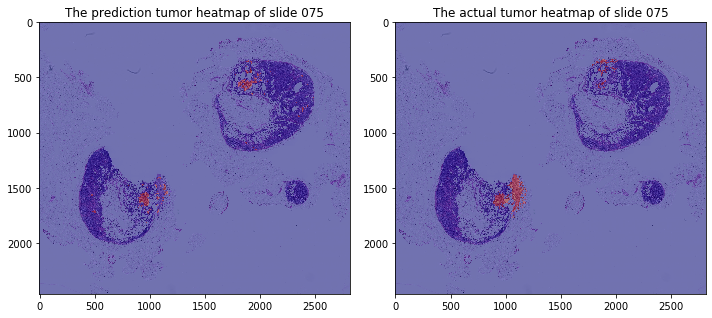

In [0]:
plot_final_result(testset_tumor_slide[0], testset_mask_slide[0], 
                  pre_test1, act_test1, 0.95, 5, 'slide 075')

The final AUC score is 0.9884704634173699
The final precision score is 0.5125570776255708
The final recall score is 0.7288961038961039
The final f1_score is 0.6018766756032172




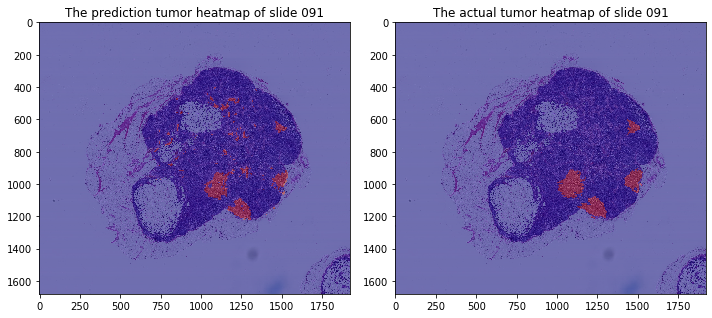

In [0]:
plot_final_result(testset_tumor_slide[1], testset_mask_slide[1], 
                  pre_test2, act_test2, 0.95, 5, 'slide 091')

The final AUC score is 0.9718873986827975
The final precision score is 0.18255395683453238
The final recall score is 0.4572072072072072
The final f1_score is 0.26092544987146526




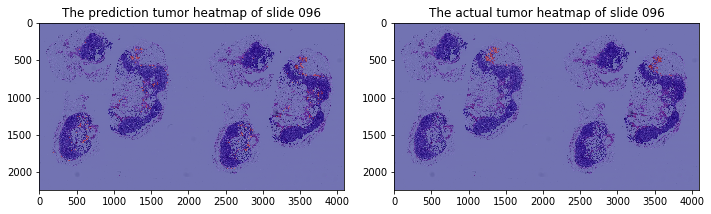

In [0]:
plot_final_result(testset_tumor_slide[2], testset_mask_slide[2], 
                  pre_test3, act_test3, 0.9, 5, 'slide 096')

NB2 Finished